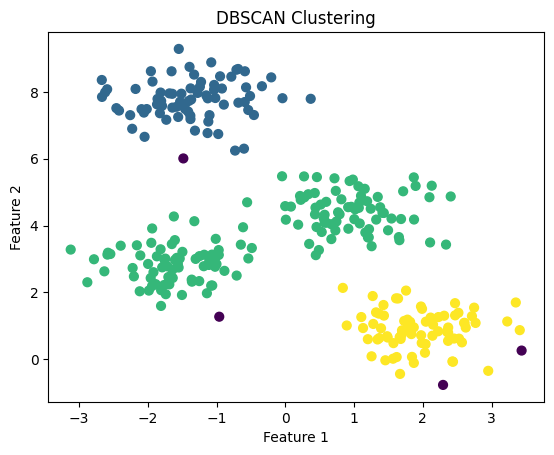

array([ 2,  0,  1,  0,  2, -1,  1,  1,  0,  0,  1,  0,  1,  0,  2,  1,  1,
        2,  1,  1,  2,  2,  1,  1,  1,  1,  2,  1,  1,  1,  0,  0,  1,  0,
        0,  0,  0,  0,  1,  2,  1,  1,  1,  1,  1,  1,  0,  1,  0,  2,  1,
        2,  0,  2,  2,  1,  0,  1,  0,  2,  0,  1,  0,  1,  1,  1,  0,  2,
        0,  1,  1,  1,  0,  1,  1,  0,  1,  1,  2,  0,  2,  1,  2,  2,  0,
        1,  2,  1,  0,  0,  1,  2,  0,  1,  1,  1,  2,  2,  1,  1,  0,  2,
        0,  2,  1,  2,  2,  1,  0,  1,  1,  1,  2,  0,  2,  1,  0,  2,  2,
        1,  1,  2,  1,  2,  2,  2,  2,  1,  2,  1,  0,  1,  1,  2,  0,  1,
        1,  0,  1,  0,  0,  1,  1,  1,  1,  1,  0,  1,  0,  0,  0,  1,  0,
        1,  2,  1,  0,  1,  2,  1,  0,  1,  1,  2,  1,  1, -1,  1,  2,  1,
        1,  0,  2,  1,  1,  0,  2,  2,  1,  1,  2,  1,  1,  1,  1,  1,  1,
        1,  2,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  1,  1,  2,  1,
        1, -1,  1,  0,  1,  0,  1,  1,  1,  1,  0,  1,  1,  2,  2,  1,  0,
        2,  2,  1,  2,  1

In [15]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Generate sample data
X, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

# Fit DBSCAN
dbscan = DBSCAN(eps=0.7, min_samples=5)
labels = dbscan.fit_predict(X)

# Visualize the clustering results
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

labels


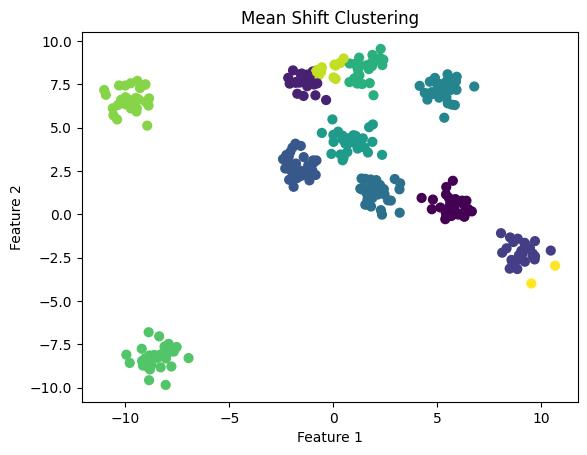

In [7]:
from sklearn.cluster import MeanShift, estimate_bandwidth
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Generate sample data
X, _ = make_blobs(n_samples=300, centers=10, cluster_std=0.60, random_state=0)

# Estimate bandwidth
bandwidth = estimate_bandwidth(X, quantile=0.05)

# Fit Mean Shift
mean_shift = MeanShift(bandwidth=bandwidth)
labels = mean_shift.fit_predict(X)

# Visualize the clustering results
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')
plt.title('Mean Shift Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


In [4]:
import sys
sys.path.append('../')
import numpy as np
from utils import list_s3_prefix, get_file_from_s3
import pandas as pd

surveys = set()
for path in list_s3_prefix("human_resp/"):
    if path.startswith("human_resp/American_Trends_Panel"):
        # Extract the folder name
        folder = path.split("/")[1]
        surveys.add(folder)
surveys = sorted(list(surveys))
mapping = np.load(get_file_from_s3('human_resp/topic_mapping.npy'), allow_pickle=True)
mapping = mapping.item()



In [5]:
import pandas as pd

topics_list = []
for survey in surveys:
    file_key = f"human_resp/{survey}/info.csv"
    info_df = pd.read_csv(get_file_from_s3(file_key))

    cgs, fgs = [], []
    for idx, row in info_df.iterrows():
        question = row['question']
        ref = f"[{'/'.join([char for char in eval(row['references'])])}]"
        key = ' '.join((question, ref))
        topics = mapping[key]
        cgs += topics['cg']
        fgs += topics['fg']

    print(survey)
    print('cgs:', set(cgs))
    # print('fgs:', set(fgs))
    print()
    topics_list.append(set(cgs))

American_Trends_Panel_W26
cgs: {'job/career', 'crime/security', 'healthcare system', 'community health', 'personal finance'}

American_Trends_Panel_W27
cgs: {'job/career', 'political issues', 'future', 'corporations, banks, technology and automation', 'healthcare system'}

American_Trends_Panel_W29
cgs: {'job/career', 'self-perception and values', 'political issues', 'discrimination', 'status in life', 'gender & sexuality', 'race', 'corporations, banks, technology and automation', 'crime/security', 'community health', 'global attitudes and foreign policy', 'relationships and family', 'personal health', 'personal finance', 'immigration', 'science'}

American_Trends_Panel_W32
cgs: {'job/career', 'self-perception and values', 'political issues', 'future', 'economy and inequality', 'discrimination', 'status in life', 'education', 'gender & sexuality', 'race', 'news, social media, data, privacy', 'community health', 'relationships and family', 'healthcare system', 'personal finance', 'immig

In [9]:
def jaccard_similarity(set1, set2):
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union)

def find_most_similar(target_set, sets_list, top_n=1):
    similarities = []
    for s_idx, s in enumerate(sets_list):
        similarity = jaccard_similarity(target_set, s)
        similarities.append((s_idx, similarity, s))
    # Sort by similarity in descending order
    similarities.sort(reverse=True, key=lambda x: x[1])
    # Return the top N most similar sets
    return similarities[:top_n]

# Example usage:
target_set = topics_list[0]
sets_list = topics_list

most_similar_sets = find_most_similar(target_set, sets_list, top_n=3)
for idx, similarity, s in most_similar_sets:
    print(f"{idx}, Similarity: {similarity}, Set: {s}")
    print(surveys[idx])
    print()


0, Similarity: 1.0, Set: {'job/career', 'crime/security', 'healthcare system', 'community health', 'personal finance'}
American_Trends_Panel_W26

12, Similarity: 0.35714285714285715, Set: {'job/career', 'political issues', 'self-perception and values', 'economy and inequality', 'education', 'race', 'crime/security', 'corporations, banks, technology and automation', 'healthcare system', 'community health', 'personal finance', 'immigration', 'science', 'leadership'}
American_Trends_Panel_W54

8, Similarity: 0.29411764705882354, Set: {'job/career', 'self-perception and values', 'political issues', 'economy and inequality', 'discrimination', 'status in life', 'education', 'gender & sexuality', 'religion', 'race', 'crime/security', 'relationships and family', 'healthcare system', 'community health', 'personal health', 'personal finance', 'science'}
American_Trends_Panel_W43



In [7]:
most_similar_sets

[(0,
  1.0,
  {'community health',
   'crime/security',
   'healthcare system',
   'job/career',
   'personal finance'}),
 (12,
  0.35714285714285715,
  {'community health',
   'corporations, banks, technology and automation',
   'crime/security',
   'economy and inequality',
   'education',
   'healthcare system',
   'immigration',
   'job/career',
   'leadership',
   'personal finance',
   'political issues',
   'race',
   'science',
   'self-perception and values'}),
 (8,
  0.29411764705882354,
  {'community health',
   'crime/security',
   'discrimination',
   'economy and inequality',
   'education',
   'gender & sexuality',
   'healthcare system',
   'job/career',
   'personal finance',
   'personal health',
   'political issues',
   'race',
   'relationships and family',
   'religion',
   'science',
   'self-perception and values',
   'status in life'})]

In [2]:
import sys
sys.path.append('../')
import numpy as np
from utils import list_s3_prefix, get_file_from_s3
import pandas as pd

surveys = set()
for path in list_s3_prefix("human_resp/"):
    if path.startswith("human_resp/American_Trends_Panel"):
        # Extract the folder name
        folder = path.split("/")[1]
        surveys.add(folder)

sorted_surveys = sorted(list(surveys))
surveys = [sorted_surveys[0]]

In [3]:
surveys

['American_Trends_Panel_W26']

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained('Salesforce/SFR-Embedding-2_R')
model = AutoModel.from_pretrained('Salesforce/SFR-Embedding-2_R', device_map='auto')


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [34]:
import os

os.listdir('sm_local/outputs_haiku_gmm10_single_example/cleaned')

['cleaned_high_level_personas_American_Trends_Panel_W29.json',
 'cleaned_high_level_personas_American_Trends_Panel_W34.json',
 'cleaned_mid_level_personas_American_Trends_Panel_W34.json',
 'cleaned_high_level_personas_American_Trends_Panel_W26.json',
 'cleaned_mid_level_personas_American_Trends_Panel_W26.json',
 'cleaned_low_level_personas_American_Trends_Panel_W27.json',
 'cleaned_low_level_personas_American_Trends_Panel_W34.json',
 'cleaned_mid_level_personas_American_Trends_Panel_W32.json',
 'cleaned_low_level_personas_American_Trends_Panel_W26.json',
 'cleaned_low_level_personas_American_Trends_Panel_W29.json',
 'cleaned_mid_level_personas_American_Trends_Panel_W27.json',
 'cleaned_low_level_personas_American_Trends_Panel_W32.json']

In [18]:
import json
import torch
from torch import Tensor
from utils import get_file_from_s3, persona_dim_dict_list_to_object_list

def last_token_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
    if left_padding:
        return last_hidden_states[:, -1]
    else:
        sequence_lengths = attention_mask.sum(dim=1) - 1
        batch_size = last_hidden_states.shape[0]
        return last_hidden_states[torch.arange(batch_size, device=last_hidden_states.device), sequence_lengths]


with open(f"sm_local/outputs_haiku_gmm10_single_example/cleaned/cleaned_high_level_personas_American_Trends_Panel_W26.json", 'r') as f:
    data = json.load(f)

data = [_.linearize() for _ in persona_dim_dict_list_to_object_list(data)]
formatted = data

In [19]:
# embeddings = []
# for text in formatted:
#     batch_dict = tokenizer([text], max_length=4096, padding=True, truncation=True, return_tensors="pt")
#     with torch.inference_mode():
#         outputs = model(**batch_dict)
#         embed = last_token_pool(outputs.last_hidden_state, batch_dict['attention_mask'])[0]
#     embeddings.append(embed)
# embeddings = torch.stack(embeddings, axis=0)

In [29]:
batch_dict = tokenizer(formatted, max_length=4096, padding=True, truncation=True, return_tensors="pt")
with torch.inference_mode():
    outputs = model(**batch_dict)
    embeddings = last_token_pool(outputs.last_hidden_state, batch_dict['attention_mask'])

embeddings.shape

torch.Size([17, 4096])

{0.7: 0.5808823704719543, 0.8: 0.10294117778539658, 0.9: 0.007352941203862429}


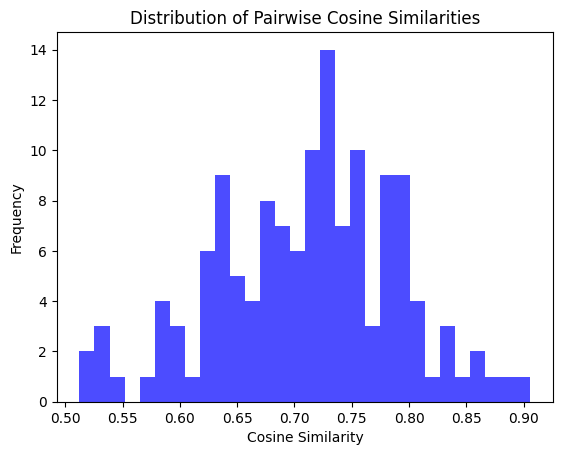

In [30]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt


# Normalize the embeddings
normalized_embeddings = F.normalize(embeddings, p=2, dim=1)

# Calculate pairwise cosine similarity
cosine_similarity_matrix = torch.mm(normalized_embeddings, normalized_embeddings.t())

# Extract upper triangle without diagonal
triu_indices = torch.triu_indices(cosine_similarity_matrix.size(0), cosine_similarity_matrix.size(1), offset=1)
pairwise_cosine_similarities = cosine_similarity_matrix[triu_indices[0], triu_indices[1]]

# Define thresholds
thresholds = [0.7, 0.8, 0.9]

# Calculate the ratios
ratios = {threshold: (pairwise_cosine_similarities > threshold).float().mean().item() for threshold in thresholds}

print(ratios)

# Convert to numpy for plotting
pairwise_cosine_similarities = pairwise_cosine_similarities.numpy()

# Plot the distribution
plt.hist(pairwise_cosine_similarities, bins=30, alpha=0.7, color='blue')
plt.title('Distribution of Pairwise Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()

In [1]:
from utils import get_cosine_similarity_metrics

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained('Salesforce/SFR-Embedding-2_R')
model = AutoModel.from_pretrained('Salesforce/SFR-Embedding-2_R', device_map='auto')


d = get_cosine_similarity_metrics("sm_local/outputs_haik·u_gmm10_single_example/", tokenizer, model)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [1]:
import numpy as np
from utils import list_s3_prefix, get_file_from_s3
import pandas as pd

surveys = set()
for path in list_s3_prefix("human_user_historyp/"):
    if path.startswith("human_resp/American_Trends_Panel"):
        # Extract the folder name
        folder = path.split("/")[1]
        surveys.add(folder)
surveys = sorted(list(surveys))
mapping = np.load(get_file_from_s3('human_resp/topic_mapping.npy'), allow_pickle=True)
mapping = mapping.item()



In [3]:
import pandas as pd

topics_list = []
for survey in surveys:
    file_key = f"human_resp/{survey}/info.csv"
    info_df = pd.read_csv(get_file_from_s3(file_key))

    cgs, fgs = [], []
    for idx, row in info_df.iterrows():
        question = row['question']
        ref = f"[{'/'.join([char for char in eval(row['references'])])}]"
        key = ' '.join((question, ref))
        topics = mapping[key]
        cgs += topics['cg']
        fgs += topics['fg']

    print(survey)
    print('cgs:', set(cgs))
    print()
    topics_list.append(set(cgs))

American_Trends_Panel_W26
cgs: {'job/career', 'personal finance', 'crime/security', 'healthcare system', 'community health'}

American_Trends_Panel_W27
cgs: {'political issues', 'job/career', 'future', 'corporations, banks, technology and automation', 'healthcare system'}

American_Trends_Panel_W29
cgs: {'political issues', 'global attitudes and foreign policy', 'job/career', 'self-perception and values', 'discrimination', 'science', 'race', 'crime/security', 'personal finance', 'gender & sexuality', 'personal health', 'immigration', 'corporations, banks, technology and automation', 'relationships and family', 'status in life', 'community health'}

American_Trends_Panel_W32
cgs: {'political issues', 'job/career', 'self-perception and values', 'discrimination', 'personal finance', 'race', 'future', 'gender & sexuality', 'economy and inequality', 'news, social media, data, privacy', 'healthcare system', 'immigration', 'education', 'relationships and family', 'status in life', 'community 

In [4]:
with open(f'prompts/determine_relevance.txt') as f:
    prompt_template = f.read()

In [6]:
print(prompt_template)

# Instruction

You are an expert in user profiling and persona extraction. Your task now is to determine whether a persona dimension is relevant for predicting a user's response to a survey topic.

The persona dimensions are represented by a list of `PersonaDimension` objects of the following definition: 

```python
@dataclass
class PersonaDimension:
    name: str  # a concise name of the persona aspect
    description: str  # a detailed description of the persona aspect
    level: str  # the abstractness level of this persona dimension, choose from ['low', 'mid', 'high']
    candidate_values: str  # the candidate values of this persona dimension
```

# Task
Output yes if the persona dimension is relevant, and no othewise.

# Input (Example)
[
    PersonaDimension(
        name="Firearm-Related Recreational Interests and Activities",
        description="The individual's involvement in recreational activities, hobbies, and interests related to firearms, such as hunting, shooting sports

In [9]:
f_string = "{aaa}, {{bbb}}"
f_string.format(aaa=1)

'1, {bbb}'

# 0726

In [3]:
import pandas as pd
from utils import list_s3_prefix, get_file_from_s3

surveys = set()
for path in list_s3_prefix("human_resp/"):
    if path.startswith("human_resp/American_Trends_Panel"):
        # Extract the folder name
        folder = path.split("/")[1]
        surveys.add(folder)
surveys = sorted(list(surveys))

In [4]:
file_key = "American_Trends_Panel_W26"
# list_s3_prefix(f"human_resp/")

survey_df = pd.read_csv(get_file_from_s3(f"human_resp/{file_key}/info.csv"))
resp_df = pd.read_csv(get_file_from_s3(f"human_resp/{file_key}/responses.csv"))
meta_df = pd.read_csv(get_file_from_s3(f"human_resp/{file_key}/metadata.csv"))

/tmp/ipykernel_2624578/1866159568.py:5: DtypeWarning: Columns (36,58,59,76) have mixed types. Specify dtype option on import or set low_memory=False.
  resp_df = pd.read_csv(get_file_from_s3(f"human_resp/{file_key}/responses.csv"))


In [5]:
survey_df

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,key,option_mapping,question,references,option_ordinal
0,0,0,0,SAFECRIME_W26,"{1.0: 'Very safe', 2.0: 'Somewhat safe', 3.0: ...","How safe, if at all, would you say your local ...","['Very safe', 'Somewhat safe', 'Not too safe',...","[1.0, 2.0, 3.0, 4.0]"
1,1,1,1,WORLDDANGER_W26,"{1.0: 'We live in a safer world', 2.0: 'We liv...","Compared to 50 years ago, do you think","['We live in a safer world', 'We live in a mor...","[1.0, 2.0, 1.5]"
2,2,2,2,WORRYA_W26,"{1.0: 'Worry a lot', 2.0: 'Worry a little', 3....","How much, if at all, do you worry about the fo...","['Worry a lot', 'Worry a little', 'Do not worr...","[1.0, 2.0, 3.0]"
3,3,3,3,WORRYB_W26,"{1.0: 'Worry a lot', 2.0: 'Worry a little', 3....","How much, if at all, do you worry about the fo...","['Worry a lot', 'Worry a little', 'Do not worr...","[1.0, 2.0, 3.0]"
4,4,4,4,WORRYC_W26,"{1.0: 'Worry a lot', 2.0: 'Worry a little', 3....","How much, if at all, do you worry about the fo...","['Worry a lot', 'Worry a little', 'Do not worr...","[1.0, 2.0, 3.0]"
...,...,...,...,...,...,...,...,...
73,73,73,73,GUNACTIVITYA_W26,"{1.0: 'Often', 2.0: 'Sometimes', 3.0: 'Hardly ...","How often, if ever, do you visit websites abou...","['Often', 'Sometimes', 'Hardly ever', 'Never',...","[1.0, 2.0, 3.0, 4.0]"
74,74,74,74,GUNACTIVITYB_W26,"{1.0: 'Often', 2.0: 'Sometimes', 3.0: 'Hardly ...","How often, if ever, do you watch TV programs a...","['Often', 'Sometimes', 'Hardly ever', 'Never',...","[1.0, 2.0, 3.0, 4.0]"
75,75,75,75,GUNACTIVITYC_W26,"{1.0: 'Often', 2.0: 'Sometimes', 3.0: 'Hardly ...","How often, if ever, do you listen to gun-orien...","['Often', 'Sometimes', 'Hardly ever', 'Never',...","[1.0, 2.0, 3.0, 4.0]"
76,76,76,76,GUNACTIVITYD_W26,"{1.0: 'Often', 2.0: 'Sometimes', 3.0: 'Hardly ...","How often, if ever, do you participate in onli...","['Often', 'Sometimes', 'Hardly ever', 'Never',...","[1.0, 2.0, 3.0, 4.0]"


In [6]:
question_key_mapping = {row['key']: {'question': row['question'], 'references': row['references']} for _, row in survey_df.iterrows()}
question_key_mapping['SAFECRIME_W26']

{'question': 'How safe, if at all, would you say your local community is from crime? Would you say it is',
 'references': "['Very safe', 'Somewhat safe', 'Not too safe', 'Not at all safe', 'Refused']"}

In [7]:
meta_keys = list(meta_df['key'])
q_keys = list(survey_df['key'])
[_ for _ in meta_keys if _ in q_keys]

[]

In [8]:
import random

random.seed(42)
test_q_keys = random.choices(q_keys, k=5)
print(test_q_keys)
train_q_keys = [_ for _ in q_keys if _ not in test_q_keys]

['GUNRESPNOKIDSB_W26', 'WORLDDANGER_W26', 'GUNIDENTITY_W26', 'REASONGUNC_W26', 'GUNRESPKIDSC_W26']


In [9]:
test_user_idx = random.choices(range(len(resp_df)), k=int(len(resp_df)*0.1))
train_user_idx = [i for i in range(len(resp_df)) if i not in test_user_idx]
test_resp_df = resp_df.iloc[test_user_idx]
train_resp_df = resp_df.iloc[train_user_idx]

In [10]:
test_resp_df[test_q_keys]

,GUNRESPNOKIDSB_W26,WORLDDANGER_W26,GUNIDENTITY_W26,REASONGUNC_W26,GUNRESPKIDSC_W26
2820,Essential,We live in a more dangerous world,NaN,NaN,NaN
3718,Essential,The world we live in is neither safer nor more...,NaN,NaN,NaN
362,NaN,The world we live in is neither safer nor more...,NaN,NaN,Essential
1758,Important but not essential,We live in a more dangerous world,Not at all important,Not a reason,NaN
124,NaN,We live in a more dangerous world,NaN,NaN,Essential
...,...,...,...,...,...
1020,NaN,We live in a more dangerous world,NaN,NaN,Important but not essential
1980,Important but not essential,The world we live in is neither safer nor more...,NaN,NaN,NaN
3541,NaN,We live in a more dangerous world,NaN,NaN,Essential
303,Important but not essential,We live in a more dangerous world,NaN,NaN,NaN


In [11]:
test_resp_df[train_q_keys]

,SAFECRIME_W26,WORRYA_W26,WORRYB_W26,WORRYC_W26,WORRYD_W26,WORRYE_W26,WORRYF_W26,WORRYG_W26,GUN_W26,GUN1_W26,...,DEFENDGUN_W26,GUNTHREAT_W26,CRIMEVICTIM_W26,MARGUN_W26,GUNASSOCIATIONA_W26,GUNACTIVITYA_W26,GUNACTIVITYB_W26,GUNACTIVITYC_W26,GUNACTIVITYD_W26,GUNACTIVITYE_W26
2820,Somewhat safe,Worry a little,Worry a little,NaN,NaN,NaN,NaN,Worry a lot,"No, I don't own any guns","No, no one else in my household owns a gun",...,No,No,No,NaN,NaN,Never,Never,Never,Never,Never
3718,Somewhat safe,Do not worry at all,Do not worry at all,Do not worry at all,NaN,NaN,NaN,Do not worry at all,"No, I don't own any guns","No, no one else in my household owns a gun",...,No,No,No,NaN,NaN,Never,Never,Never,Never,Never
362,Somewhat safe,NaN,NaN,NaN,Do not worry at all,Worry a little,Worry a little,Do not worry at all,"No, I don't own any guns","No, no one else in my household owns a gun",...,No,Yes,Yes,NaN,NaN,Never,Never,Never,Never,Never
1758,Somewhat safe,Worry a little,Worry a little,NaN,NaN,NaN,NaN,Worry a little,"Yes, I own a gun","Yes, someone else in my household owns a gun",...,No,No,No,Yes,No,Hardly ever,Hardly ever,Never,Never,Never
124,Refused,NaN,NaN,NaN,Worry a little,Worry a little,Worry a little,Worry a little,"No, I don't own any guns","No, no one else in my household owns a gun",...,No,No,No,NaN,NaN,Never,Never,Hardly ever,Never,Hardly ever
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,Not too safe,NaN,NaN,NaN,Do not worry at all,Worry a little,Do not worry at all,Worry a little,"No, I don't own any guns","No, no one else in my household owns a gun",...,Refused,No,No,NaN,NaN,Never,Never,Never,Never,Never
1980,Very safe,Do not worry at all,Do not worry at all,NaN,NaN,NaN,NaN,Worry a little,"No, I don't own any guns","No, no one else in my household owns a gun",...,No,No,No,NaN,NaN,Never,Never,Never,Never,Never
3541,Very safe,NaN,NaN,NaN,Do not worry at all,Worry a little,Worry a little,Worry a little,"No, I don't own any guns","No, no one else in my household owns a gun",...,No,No,No,NaN,NaN,Never,Never,Never,Never,Never
303,Somewhat safe,Worry a little,Do not worry at all,Do not worry at all,NaN,NaN,NaN,Worry a little,"No, I don't own any guns","Yes, someone else in my household owns a gun",...,No,No,No,NaN,NaN,Never,Never,Never,Never,Never


In [15]:
test_resp_df.iloc[0][meta_keys].to_dict()

{'CREGION': 'West',
 'AGE': '65+',
 'SEX': 'Female',
 'EDUCATION': 'College graduate/some postgrad',
 'CITIZEN': 'Yes',
 'MARITAL': 'Married',
 'RELIG': 'Protestant',
 'RELIGATTEND': 'Never',
 'POLPARTY': 'Republican',
 'INCOME': 'Refused',
 'POLIDEOLOGY': 'Very conservative',
 'RACE': 'White'}

In [28]:
from utils import get_llm_response
from tqdm import tqdm
import json

use_demo = True

prompt_name = 'prompts/vanilla_predict.txt' if not use_demo else 'prompts/vanilla_demo_predict.txt'
with open(prompt_name) as f:
    pred_prompt_template = f.read()

cnt = 0
correct = 0
logs = []
for user_idx, row in tqdm(test_resp_df.iterrows(), total=len(test_resp_df)):
    # construct user history
    user_history = {}
    for q_key in train_q_keys:
        question = question_key_mapping[q_key]['question']
        references = question_key_mapping[q_key]['references']
        user_history[f"Question: {question}; Reference: {references}"] = test_resp_df.at[user_idx, q_key]
    
    if use_demo:
        demo = row[meta_keys].to_dict()
        
    # for each legal test question, predict
    for q_key in test_q_keys:
        gold_answer = row[q_key]
        if pd.notna(gold_answer):
            question = question_key_mapping[q_key]['question']
            references = question_key_mapping[q_key]['references']
            if use_demo:
                input_dict = {
                    "user_history": user_history,
                    "question": question,
                    "options": references,
                    "demo": demo
                }
            else:
                input_dict = {
                    "user_history": user_history,
                    "question": question,
                    "options": references
                }
            pred_prompt = pred_prompt_template.format(**input_dict)
            raise Exception(pred_prompt)
            response = get_llm_response(pred_prompt, model_id="anthropic.claude-3-sonnet-20240229-v1:0")
            
            is_correct = response == gold_answer
            if is_correct:
                correct += 1
            cnt += 1
            logs.append({
                "is_correct": is_correct,
                "question": question,
                "references": references,
                "prediction": response,
                "gold_answer": gold_answer
            })
            with open('temp_log.json', 'w') as f:
                json.dump(logs, f, indent=4)

  0%|          | 0/416 [00:00<?, ?it/s]


Exception: # Instruction
You are a user response prediction expert. You will be given a survey question, the options for that survey question, the participant's demographic background, and the participant's response to some other questions in the same survey. Your task is to predict the participant's response to the specific survey question, by selecting the most likely option for the participant. Only respond with one of the options and nothing else.

# Participant's demographic background
{'CREGION': 'West', 'AGE': '65+', 'SEX': 'Female', 'EDUCATION': 'College graduate/some postgrad', 'CITIZEN': 'Yes', 'MARITAL': 'Married', 'RELIG': 'Protestant', 'RELIGATTEND': 'Never', 'POLPARTY': 'Republican', 'INCOME': 'Refused', 'POLIDEOLOGY': 'Very conservative', 'RACE': 'White'}

# Participant's responses to other questions in the survey
{"Question: How safe, if at all, would you say your local community is from crime? Would you say it is; Reference: ['Very safe', 'Somewhat safe', 'Not too safe', 'Not at all safe', 'Refused']": 'Somewhat safe', "Question: How much, if at all, do you worry about the following happening to you? Having your home broken into; Reference: ['Worry a lot', 'Worry a little', 'Do not worry at all', 'Refused']": 'Worry a little', "Question: How much, if at all, do you worry about the following happening to you? Being the victim of a terrorist attack; Reference: ['Worry a lot', 'Worry a little', 'Do not worry at all', 'Refused']": 'Worry a little', "Question: How much, if at all, do you worry about the following happening to you? Losing your job; Reference: ['Worry a lot', 'Worry a little', 'Do not worry at all', 'Refused']": nan, "Question: How much, if at all, do you worry about the following happening to you? Not being able to pay your bills; Reference: ['Worry a lot', 'Worry a little', 'Do not worry at all', 'Refused']": nan, "Question: How much, if at all, do you worry about the following happening to you? Being the victim of a violent crime; Reference: ['Worry a lot', 'Worry a little', 'Do not worry at all', 'Refused']": nan, "Question: How much, if at all, do you worry about the following happening to you? Being the victim of a mass shooting; Reference: ['Worry a lot', 'Worry a little', 'Do not worry at all', 'Refused']": nan, "Question: How much, if at all, do you worry about the following happening to you? Having a personal health crisis; Reference: ['Worry a lot', 'Worry a little', 'Do not worry at all', 'Refused']": 'Worry a lot', 'Question: Do you personally own any guns (not including air guns, such as paintball, BB or pellet guns)?; Reference: [\'Yes, I own a gun\', "No, I don\'t own any guns", \'Refused\']': "No, I don't own any guns", "Question: Does anyone else in your household own any guns (not including air guns, such as paintball, BB or pellet guns)?; Reference: ['Yes, someone else in my household owns a gun', 'No, no one else in my household owns a gun', 'Refused']": 'No, no one else in my household owns a gun', "Question: Have you ever owned a gun at any point in your life, or have you never owned a gun?; Reference: ['Yes, have owned a gun', 'No, have never owned a gun', 'Refused']": 'No, have never owned a gun', "Question: Which best describes you?; Reference: ['I could never see myself not owning a gun', 'I could see myself not owning a gun at some point in the future', 'Refused']": nan, "Question: Do you currently or have you ever owned a shotgun?; Reference: ['Yes, I currently own', 'Yes, I have owned in the past but do not currently own', 'No, I have never owned', 'Refused']": nan, "Question: Regardless of whether or not you own a gun, have you ever fired a gun?; Reference: ['Yes, I have fired a gun', 'No, I have never fired a gun', 'Refused']": 'No, I have never fired a gun', "Question: Please indicate whether the following is a major reason, a minor reason, or not a reason why you own a gun. For protection; Reference: ['Major reason', 'Minor reason', 'Not a reason', 'Refused']": nan, "Question: Please indicate whether the following is a major reason, a minor reason, or not a reason why you own a gun. For hunting; Reference: ['Major reason', 'Minor reason', 'Not a reason', 'Refused']": nan, "Question: Please indicate whether the following is a major reason, a minor reason, or not a reason why you own a gun. As part of a gun collection; Reference: ['Major reason', 'Minor reason', 'Not a reason', 'Refused']": nan, "Question: Please indicate whether the following is a major reason, a minor reason, or not a reason why you own a gun. For my job; Reference: ['Major reason', 'Minor reason', 'Not a reason', 'Refused']": nan, "Question: Which of the following is the most important reason why you own a gun?; Reference: ['For protection', 'For hunting', 'For sport shooting, including target shooting and trap and skeet', 'As part of a gun collection', 'For my job', 'Refused']": nan, "Question: As far as you know, how many of your friends, if any, own guns?; Reference: ['All or most', 'Some', 'Only a few', 'None', 'Refused']": nan, "Question: Do you feel that society in general tends to look at most gun owners in a positive way or a negative way?; Reference: ['Positive way', 'Negative way', 'Refused']": 'Negative way', "Question: Do you feel that people in your local community tend to look at most gun owners in a positive way or a negative way?; Reference: ['Positive way', 'Negative way', 'Refused']": 'Positive way', "Question: How often, if ever, do you go shooting or to a gun range?; Reference: ['Often', 'Sometimes', 'Rarely', 'Never', 'Refused']": nan, "Question: Does having a gun in your household make you feel; Reference: ['Safer than you would feel without a gun in your household', 'Less safe than you would feel without a gun in your household', 'No more or less safe', 'Refused']": nan, "Question: Would having a gun in your household make you feel; Reference: ['Safer than you feel without a gun in your household', 'Less safe than you feel without a gun in your household', 'No more or less safe', 'Refused']": 'No more or less safe', "Question: Have you ever taken any gun safety courses such as weapons training, hunter safety or firearm safety?; Reference: ['Yes', 'No', 'Refused']": 'No', "Question: Thinking about when you're at home, would you say there is a gun that is both loaded and easily accessible to you; Reference: ['All of the time', 'Most of the time', 'Only some of the time', 'Never', 'Refused']": nan, "Question: In general, as far as you know, how many of the guns in your home would you say are kept in a locked place?; Reference: ['All are kept in a locked place', 'Some are kept in a locked place and some are not', 'None are kept in a locked place', 'Refused']": nan, "Question: In general, as far as you know, how many of the guns in your home would you say are kept loaded?; Reference: ['All are kept loaded', 'Some are kept loaded and some are not', 'None are kept loaded', 'Refused']": nan, "Question: In general, is the gun in your home kept in a locked place, or not?; Reference: ['Yes, kept in a locked place', 'No, not kept in a locked place', 'Refused']": nan, "Question: In general, is the gun in your home kept loaded, or not?; Reference: ['Yes, kept loaded', 'No, not kept loaded', 'Refused']": nan, "Question: How much, if at all, do you think the ease with which people can legally obtain guns contributes to gun violence in the country today?; Reference: ['A great deal', 'A fair amount', 'Not too much', 'Not at all', 'Refused']": 'A great deal', "Question: How much, if at all, do you think the ease with which people can illegally obtain guns contributes to gun violence in the country today?; Reference: ['A great deal', 'A fair amount', 'Not too much', 'Not at all', 'Refused']": 'A great deal', "Question: How much, if at all, do you think the amount of gun violence in movies and television contributes to gun violence in the country today?; Reference: ['A great deal', 'A fair amount', 'Not too much', 'Not at all', 'Refused']": 'A great deal', "Question: How much, if at all, do you think lack of economic opportunities contributes to gun violence in the country today?; Reference: ['A great deal', 'A fair amount', 'Not too much', 'Not at all', 'Refused']": 'Not too much', "Question: How much, if at all, do you think the amount of gun violence in video games contributes to gun violence in the country today?; Reference: ['A great deal', 'A fair amount', 'Not too much', 'Not at all', 'Refused']": nan, "Question: How much, if at all, do you think family instability contributes to gun violence in the country today?; Reference: ['A great deal', 'A fair amount', 'Not too much', 'Not at all', 'Refused']": nan, "Question: How much of a problem was gun violence in the community where you spent the majority of time when you were growing up?; Reference: ['A very big problem', 'A moderately big problem', 'A small problem', 'Not a problem at all', 'Refused']": 'Not a problem at all', "Question: Thinking about when you were growing up, as far as you know, were there ever any guns in your household or not?; Reference: ['Yes, there were guns in my household', 'No, there were no guns in my household', 'I am not sure if there were guns in my household', 'Refused']": 'No, there were no guns in my household', "Question: Would you say the following was a reason or was not a reason why there were guns in your household when you were growing up? For protection; Reference: ['Yes, was a reason', 'No, was not a reason', 'Refused']": nan, "Question: Would you say the following was a reason or was not a reason why there were guns in your household when you were growing up? For hunting; Reference: ['Yes, was a reason', 'No, was not a reason', 'Refused']": nan, "Question: Would you say the following was a reason or was not a reason why there were guns in your household when you were growing up? For sport shooting, including target shooting and trap and skeet; Reference: ['Yes, was a reason', 'No, was not a reason', 'Refused']": nan, "Question: Thinking about the people in the community where you spent the majority of time when you were growing up, as far as you know, how many people owned guns?; Reference: ['All or most', 'Some', 'Only a few', 'None', 'Refused']": 'Only a few', "Question: How often, if ever, did you go shooting or to a gun range when you were growing up?; Reference: ['Often', 'Sometimes', 'Hardly ever', 'Never', 'Refused']": nan, "Question: How often, if ever, did you use air guns, such as paintball, BB or pellet guns when you were growing up?; Reference: ['Often', 'Sometimes', 'Hardly ever', 'Never', 'Refused']": 'Never', "Question: Thinking about gun owners who do not have children in their home how important do you think it is for them to: Keep all of their guns in a locked place; Reference: ['Essential', 'Important but not essential', 'Not important', 'Should not be done', 'Refused']": 'Essential', "Question: Thinking about gun owners who do not have children in their home how important do you think it is for them to: Take gun safety courses; Reference: ['Essential', 'Important but not essential', 'Not important', 'Should not be done', 'Refused']": 'Refused', "Question: Thinking about gun owners who do not have children in their home how important do you think it is for them to: Advise visitors that there are guns in the house; Reference: ['Essential', 'Important but not essential', 'Not important', 'Should not be done', 'Refused']": 'Essential', "Question: Thinking about gun owners who do not have children in their home how important do you think it is for them to: Advise visitors with children that there are guns in the house; Reference: ['Essential', 'Important but not essential', 'Not important', 'Should not be done', 'Refused']": nan, "Question: Thinking about gun owners who do not have children in their home how important do you think it is for them to: Store guns and ammunition separately; Reference: ['Essential', 'Important but not essential', 'Not important', 'Should not be done', 'Refused']": 'Essential', "Question: Thinking about gun owners who do not have children in their home how important do you think it is for them to: Keep their shooting skills up-to-date; Reference: ['Essential', 'Important but not essential', 'Not important', 'Should not be done', 'Refused']": 'Essential', "Question: Thinking about gun owners who have children in their home, how important do you think it is for them to: Keep all of their guns in a locked place; Reference: ['Essential', 'Important but not essential', 'Not important', 'Should not be done', 'Refused']": nan, "Question: Thinking about gun owners who have children in their home, how important do you think it is for them to: Keep all of their guns unloaded; Reference: ['Essential', 'Important but not essential', 'Not important', 'Should not be done', 'Refused']": nan, "Question: Thinking about gun owners who have children in their home, how important do you think it is for them to: Advise visitors that there are guns in the house; Reference: ['Essential', 'Important but not essential', 'Not important', 'Should not be done', 'Refused']": nan, "Question: Thinking about gun owners who have children in their home, how important do you think it is for them to: Advise visitors with children that there are guns in the house; Reference: ['Essential', 'Important but not essential', 'Not important', 'Should not be done', 'Refused']": nan, "Question: Thinking about gun owners who have children in their home, how important do you think it is for them to: Store guns and ammunition separately; Reference: ['Essential', 'Important but not essential', 'Not important', 'Should not be done', 'Refused']": nan, "Question: Thinking about gun owners who have children in their home, how important do you think it is for them to: Keep their shooting skills up-to-date; Reference: ['Essential', 'Important but not essential', 'Not important', 'Should not be done', 'Refused']": nan, "Question: Thinking about gun owners who have children in their home, how important do you think it is for them to: Talk to their children about gun safety; Reference: ['Essential', 'Important but not essential', 'Not important', 'Should not be done', 'Refused']": nan, "Question: For this question, please think about your child or children who are under 18. Have you ever talked with your child or children about gun safety?; Reference: ['Yes', 'No', 'I do not have children under 18', 'Refused']": nan, "Question: How often, if ever, do you carry a handgun or pistol outside your home, not including times when you are transporting it?; Reference: ['All of the time', 'Most of the time', 'Only some of the time', 'Never', 'Refused']": nan, 'Question: And would you say you never carry a handgun or pistol because you don\'t want to or for some other reason?; Reference: ["Don\'t want to carry", \'Some other reason\', \'Refused\']': nan, 'Question: Which comes closer to your view, even if neither is exactly right?; Reference: [\'People who want to kill or harm others will find a way to do it whether they have a gun or not\', "People who want to kill or harm others are less likely to do it if they don\'t have a gun", \'Refused\']': "People who want to kill or harm others are less likely to do it if they don't have a gun", 'Question: Thinking about people who commit suicide using a gun, which comes closer to your view, even if neither is exactly right?; Reference: [\'They would find a way to do it whether they had access to a gun or not\', "They would be less likely to do it if they didn\'t have access to a gun", \'Refused\']': nan, "Question: Not including in military combat or as part of your job, have you ever used a gun to defend yourself, your family or possessions, either by firing it or threatening to fire it?; Reference: ['Yes', 'No', 'Refused']": 'No', "Question: Has anyone ever used a gun to threaten or intimidate you or someone in your family?; Reference: ['Yes', 'No', 'Refused']": 'No', "Question: Have you ever been a victim of a violent crime, whether a gun was used or not?; Reference: ['Yes', 'No', 'Refused']": 'No', "Question: Now thinking about your spouse or partner. Does your spouse or partner own any guns?; Reference: ['Yes', 'No', 'Refused']": nan, "Question: Are you currently a member of a gun or shooting club or gun range; Reference: ['Yes', 'No', 'Refused']": nan, "Question: How often, if ever, do you visit websites about guns, hunting or other shooting sports; Reference: ['Often', 'Sometimes', 'Hardly ever', 'Never', 'Refused']": 'Never', "Question: How often, if ever, do you watch TV programs about guns or watch gun-oriented videos; Reference: ['Often', 'Sometimes', 'Hardly ever', 'Never', 'Refused']": 'Never', "Question: How often, if ever, do you listen to gun-oriented podcasts or radio shows; Reference: ['Often', 'Sometimes', 'Hardly ever', 'Never', 'Refused']": 'Never', "Question: How often, if ever, do you participate in online discussion forums about guns; Reference: ['Often', 'Sometimes', 'Hardly ever', 'Never', 'Refused']": 'Never', "Question: How often, if ever, do you attend gun shows; Reference: ['Often', 'Sometimes', 'Hardly ever', 'Never', 'Refused']": 'Never'}

# Survey Question
Thinking about gun owners who do not have children in their home how important do you think it is for them to: Keep all of their guns unloaded

# Survey Question Options
['Essential', 'Important but not essential', 'Not important', 'Should not be done', 'Refused']

# Your Prediction of the Participant's response


# 0726 infer persona

In [30]:
level = 'high'

persona_path = f"sm_local/outputs_sonnet_kmeans10_single_example/cleaned/cleaned_{level}_level_personas_{file_key}.json"

In [36]:
import json
with open(persona_path, 'r') as f:
    all_persona = json.load(f)

for persona_dim in all_persona:
    print(persona_dim)

{'name': 'Core Personal Values', 'description': "The participant's fundamental values, principles, and beliefs that guide their life decisions and shape their worldview on issues such as personal safety, freedom, self-reliance, non-violence, societal responsibility, and environmental conservation.", 'level': 'high', 'candidate_values': ['values personal safety/security', 'values personal freedom/individual rights', 'values self-reliance/self-sufficiency', 'values non-violence', 'values societal responsibility', 'values environmental conservation']}
{'name': 'Worldview and Belief System', 'description': "The participant's overall belief system, worldview, and attitudes towards societal issues, crime, violence, political ideologies, cultural values, and the role of socioeconomic factors.", 'level': 'high', 'candidate_values': ['conservative worldview', 'liberal worldview', 'moderate worldview', 'individualistic worldview', 'collectivistic worldview', 'progressive worldview']}
{'name': 'R

In [39]:
prompt_name = 'prompts/infer_persona_from_user_history.txt'
with open(prompt_name) as f:
    prompt_template = f.read()

input_dict = {
    "user_history": user_history,
    "persona_dim": persona_dim,
}
prompt = prompt_template.format(**input_dict)
response = get_llm_response(prompt, model_id="anthropic.claude-3-sonnet-20240229-v1:0")

In [ ]:
class Args:
    def __init__(self):
        self.exp_setting = "vanilla_demo_persona"
        self.log_name = "temp.json"
        self.survey_name = "American_Trends_Panel_W26"


from experiment.predict import main

args = Args()

main(args)

In [2]:
import json

with open("date0729_midterm_personas_full_sonnet.json", 'r') as f:
    data = json.load(f)

In [3]:
data.keys()

dict_keys(['2820', '3718', '362', '1758', '124', '911', '2106', '110', '828', '2708', '2271', '918', '2456', '3373', '27', '3358', '2909', '1418', '648', '3989', '1402', '386', '403', '3532', '2516', '3364', '3041', '2234', '4055', '1577', '2300', '3456', '2577', '3591', '2406', '2936', '190', '949', '1206', '332', '970', '420', '1158', '2649', '1520', '1542', '873', '1112', '3903', '2701', '2538', '713', '3039', '681', '1581', '4124', '2667', '2321', '2853', '3513', '3234', '954', '133', '1314', '1115', '879', '3930', '3652', '1311', '2731', '1648', '3811', '1912', '1104', '1027', '2339', '1095', '2436', '3742', '1664', '914', '4157', '2123', '378', '196', '457', '2615', '3301', '1759', '264', '1590', '4151', '2205', '4047', '3587', '47', '3003', '2841', '2238', '2671', '464', '1812', '1891', '3975', '3650', '1097', '2086', '744', '3803', '3628', '1243', '2663', '637', '3178', '2248', '3245', '2210', '2', '1351', '81', '3872', '3662', '3466', '1281', '241', '3659', '3946', '357', '202

In [4]:
with open("sm_local/outputs_sonnet_kmeans10_single_example/extraction/personas_extracted_from_question_American_Trends_Panel_W26.json", "r") as f:
    extraction = json.load(f)

In [5]:
len(extraction)

extraction[21]['response']

[{'name': 'Gun Ownership Status',
  'description': 'whether the person currently owns a gun or not',
  'level': 'low',
  'candidate_values': "['gun owner', 'non-gun owner']"},
 {'name': 'Reasons for Gun Ownership',
  'description': 'the motivations and purposes behind owning a gun, such as self-defense, hunting, or sport shooting',
  'level': 'mid',
  'candidate_values': "['self-defense', 'hunting', 'sport shooting', 'collection', 'other']"},
 {'name': 'Attitudes Towards Guns',
  'description': "the person's overall beliefs, feelings, and perspectives on gun ownership and gun rights",
  'level': 'mid',
  'candidate_values': "['positive attitude', 'negative attitude', 'neutral attitude']"},
 {'name': 'Cultural Background',
  'description': 'the cultural or regional context in which the person was raised, which may influence their views on gun ownership',
  'level': 'mid',
  'candidate_values': "['pro-gun culture', 'anti-gun culture', 'neutral culture']"},
 {'name': 'Personal Values',
  

In [6]:
import pandas as pd
from utils import get_file_from_s3

test_q_keys = ['GUNRESPNOKIDSB_W26', 'WORLDDANGER_W26', 'GUNIDENTITY_W26', 'REASONGUNC_W26', 'GUNRESPKIDSC_W26']

survey_df = pd.read_csv(get_file_from_s3(f"human_resp/American_Trends_Panel_W26/info.csv"))

In [7]:
survey_df[survey_df['key'].isin(test_q_keys)][['key', 'question', 'references']]

,key,question,references
1,WORLDDANGER_W26,"Compared to 50 years ago, do you think","['We live in a safer world', 'We live in a mor..."
17,REASONGUNC_W26,Please indicate whether the following is a maj...,"['Major reason', 'Minor reason', 'Not a reason..."
21,GUNIDENTITY_W26,"How important, if at all, is being a gun owner...","['Very important', 'Somewhat important', 'Not ..."
49,GUNRESPNOKIDSB_W26,Thinking about gun owners who do not have chil...,"['Essential', 'Important but not essential', '..."
57,GUNRESPKIDSC_W26,Thinking about gun owners who have children in...,"['Essential', 'Important but not essential', '..."


In [8]:
q_indices = [survey_df.index[survey_df['key'] == key].tolist()[0] for key in test_q_keys]  # This has to be done this way because test_q_keys can be not in order
with open("sm_local/outputs_sonnet_kmeans10_single_example/extraction/personas_extracted_from_question_American_Trends_Panel_W26.json", "r") as f:
    extraction = json.load(f)
original_extraction = [extraction[idx]['response'] for idx in q_indices]
key_to_original_extraction = dict(zip(test_q_keys, original_extraction))

clean = []
for level in ['high', 'mid', 'low']:
    with open(f"sm_local/outputs_sonnet_kmeans10_single_example/cleaned/cleaned_{level}_level_personas_American_Trends_Panel_W26.json", 'r') as f:
        clean += json.load(f)


In [9]:
key_to_original_extraction['GUNRESPNOKIDSB_W26']

[{'name': 'Gun Ownership Status',
  'description': 'whether the person owns guns or not',
  'level': 'low',
  'candidate_values': "['gun owner', 'non-gun owner']"},
 {'name': 'Household Composition',
  'description': 'whether there are children present in the household',
  'level': 'low',
  'candidate_values': "['children present', 'no children present']"},
 {'name': 'Gun Safety Attitudes',
  'description': 'beliefs and attitudes towards gun safety practices',
  'level': 'mid',
  'candidate_values': "['prioritizes gun safety', 'indifferent to gun safety']"},
 {'name': 'Risk Perception',
  'description': 'perception of the risks associated with loaded guns in the home',
  'level': 'mid',
  'candidate_values': "['high risk perception', 'low risk perception']"},
 {'name': 'Personal Values',
  'description': 'core values related to safety, responsibility, and risk management',
  'level': 'high',
  'candidate_values': "['values safety', 'values personal freedom']"},
 {'name': 'Political Ide

In [10]:
clean

[{'name': 'Core Personal Values',
  'description': "The participant's fundamental values, principles, and beliefs that guide their life decisions and shape their worldview on issues such as personal safety, freedom, self-reliance, non-violence, societal responsibility, and environmental conservation.",
  'level': 'high',
  'candidate_values': ['values personal safety/security',
   'values personal freedom/individual rights',
   'values self-reliance/self-sufficiency',
   'values non-violence',
   'values societal responsibility',
   'values environmental conservation']},
 {'name': 'Worldview and Belief System',
  'description': "The participant's overall belief system, worldview, and attitudes towards societal issues, crime, violence, political ideologies, cultural values, and the role of socioeconomic factors.",
  'level': 'high',
  'candidate_values': ['conservative worldview',
   'liberal worldview',
   'moderate worldview',
   'individualistic worldview',
   'collectivistic worldvi

In [11]:
import argparse
import json
import random
import torch
import numpy as np
import pandas as pd
from utils import list_s3_prefix, get_file_from_s3, get_formatted_persona_dim, last_token_pool
from utils import get_llm_response, CLAUDE_NAME_MAPPING
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from scipy.spatial.distance import cdist


def get_embeddings(input_texts, tokenizer, model, max_length=4096):
    embedding = []
    for text in input_texts:
        batch_dict = tokenizer([text], max_length=max_length, padding=True, truncation=True, return_tensors="pt")
        with torch.inference_mode():
            outputs = model(**batch_dict)
            embed = last_token_pool(outputs.last_hidden_state, batch_dict['attention_mask'])[0]
        embedding.append(embed)
    embedding = torch.stack(embedding, axis=0)
    return embedding


def get_query_to_persona_idx_mapping(test_q_keys, survey_df):
    tokenizer = AutoTokenizer.from_pretrained('Salesforce/SFR-Embedding-2_R')
    model = AutoModel.from_pretrained('Salesforce/SFR-Embedding-2_R', device_map='auto')

    q_indices = [survey_df.index[survey_df['key'] == key].tolist()[0] for key in test_q_keys]  # This has to be done this way because test_q_keys can be not in order
    with open("sm_local/outputs_sonnet_kmeans10_single_example/extraction/personas_extracted_from_question_American_Trends_Panel_W26.json", "r") as f:
        extraction = json.load(f)
    original_extraction = [extraction[idx]['response'] for idx in q_indices]
    original_extraction = [[get_formatted_persona_dim(persona_dim) for persona_dim in _] for _ in original_extraction]
    key_to_original_extraction = dict(zip(test_q_keys, original_extraction))

    clean = []
    for level in ['high', 'mid', 'low']:
        with open(f"sm_local/outputs_sonnet_kmeans10_single_example/cleaned/cleaned_{level}_level_personas_American_Trends_Panel_W26.json", 'r') as f:
            clean += json.load(f)
    clean = [get_formatted_persona_dim(_) for _ in clean]
    clean_embeddings = get_embeddings(clean, tokenizer, model)

    # Get the embeddings
    key_to_clean_idx = {}
    for key in test_q_keys:
        input_texts = key_to_original_extraction[key]
        left_embeddings = get_embeddings(input_texts, tokenizer, model)
        cosine_similarity = 1 - cdist(left_embeddings, clean_embeddings, 'cosine')
        most_similar_indices = np.argmax(cosine_similarity, axis=1)
        key_to_clean_idx[key] = most_similar_indices

    return key_to_clean_idx

In [12]:
key_to_clean_mapping = get_query_to_persona_idx_mapping(test_q_keys, survey_df)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [13]:
key_to_clean_mapping

{'GUNRESPNOKIDSB_W26': array([33, 41, 29, 13,  0,  6, 23, 50]),
 'WORLDDANGER_W26': array([45, 36, 40, 17, 22,  7,  0,  1,  5]),
 'GUNIDENTITY_W26': array([33, 27,  3, 26,  0,  6, 25]),
 'REASONGUNC_W26': array([33, 47, 47,  3,  0, 15, 18,  4]),
 'GUNRESPKIDSC_W26': array([41, 33, 29, 13,  0,  8,  6,  7])}

In [14]:
survey_df[survey_df['key'].isin(test_q_keys)][['key', 'question', 'references']]

,key,question,references
1,WORLDDANGER_W26,"Compared to 50 years ago, do you think","['We live in a safer world', 'We live in a mor..."
17,REASONGUNC_W26,Please indicate whether the following is a maj...,"['Major reason', 'Minor reason', 'Not a reason..."
21,GUNIDENTITY_W26,"How important, if at all, is being a gun owner...","['Very important', 'Somewhat important', 'Not ..."
49,GUNRESPNOKIDSB_W26,Thinking about gun owners who do not have chil...,"['Essential', 'Important but not essential', '..."
57,GUNRESPKIDSC_W26,Thinking about gun owners who have children in...,"['Essential', 'Important but not essential', '..."


In [17]:
q_key = "GUNRESPKIDSC_W26"

for idx in key_to_clean_mapping[q_key]:
    print(clean[idx])

{'name': 'Household Composition with Children', 'description': "The presence of children or other vulnerable individuals in the participant's household.", 'level': 'low', 'candidate_values': ['children present', 'no children present']}
{'name': 'Gun Ownership Status', 'description': 'Whether the person currently owns guns, has owned guns in the past, or has never owned guns.', 'level': 'low', 'candidate_values': ['current gun owner', 'past gun owner', 'never owned guns']}
{'name': 'Gun Safety Attitudes and Practices', 'description': "The individual's beliefs, attitudes, and practices related to safe gun handling, storage, and responsible ownership, including adherence to laws and regulations, prioritization of safety measures, and concern for child safety around firearms.", 'level': 'mid', 'candidate_values': ['prioritizes gun safety', 'indifferent to gun safety']}
{'name': 'Risk Perception of Gun Ownership', 'description': "The individual's assessment and perception of potential risks

In [18]:
key_to_original_extraction[q_key]

[{'name': 'Parental Status',
  'description': 'whether the person has children living in their home',
  'level': 'low',
  'candidate_values': ['has children at home', 'no children at home']},
 {'name': 'Gun Ownership',
  'description': 'whether the person owns guns or not',
  'level': 'low',
  'candidate_values': ['gun owner', 'non-gun owner']},
 {'name': 'Attitudes Towards Gun Safety',
  'description': 'beliefs and opinions about the importance of gun safety measures',
  'level': 'mid',
  'candidate_values': ['prioritizes gun safety', 'indifferent to gun safety']},
 {'name': 'Risk Perception',
  'description': 'assessment of the potential risks associated with gun ownership',
  'level': 'mid',
  'candidate_values': ['high risk perception', 'low risk perception']},
 {'name': 'Personal Values',
  'description': 'core values related to safety, responsibility, and protection',
  'level': 'high',
  'candidate_values': ['values safety', 'values personal freedom']},
 {'name': 'Parenting Phil

In [2]:
import os

len(os.listdir('opinions_qa/review'))

1032

In [4]:
log_name = "date0731_vanilla_demo_persona_v5low_selected_sonnetinfer_random_cand_American_Trends_Panel_W26.json"

with open(f"opinions_qa/output/{log_name}", 'r') as f:
    logs = json.load(f)
    logs = pd.DataFrame(logs)

FileNotFoundError: [Errno 2] No such file or directory: 'opinions_qa/output/date0731_vanilla_demo_persona_v5low_selected_sonnetinfer_random_cand_American_Trends_Panel_W26.json'

In [3]:
import pandas as pd 
from utils import get_file_from_s3, list_s3_prefix

file_key = "American_Trends_Panel_W26"
# list_s3_prefix(f"human_resp/")

survey_df = pd.read_csv(get_file_from_s3(f"human_resp/{file_key}/info.csv"))
resp_df = pd.read_csv(get_file_from_s3(f"human_resp/{file_key}/responses.csv"))
meta_df = pd.read_csv(get_file_from_s3(f"human_resp/{file_key}/metadata.csv"))

/tmp/ipykernel_3977969/586598587.py:8: DtypeWarning: Columns (36,58,59,76) have mixed types. Specify dtype option on import or set low_memory=False.
  resp_df = pd.read_csv(get_file_from_s3(f"human_resp/{file_key}/responses.csv"))


In [22]:
import random
random.seed(42)

test_user_idx = random.sample(range(len(resp_df)), k=int(len(resp_df)*0.1))

test_resp_df = resp_df.iloc[test_user_idx]
# test_resp_df.at[(1758, 'SAFECRIME_W26')]

In [23]:
len(set(test_resp_df['index'].unique()))

416

In [24]:
len(test_resp_df)

416